### Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
import plotly.express as px  
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display, Markdown, Latex
from datetime import datetime

### MT5 settings

In [79]:
mt5.initialize()

True

In [80]:
login = 1
password = ''
server = 'RoboForex-Pro'
mt5.login(login, password, server) 

True

### Historical Price

In [1904]:
symbol = 'XAUUSD'
timeframe = 30 # integer value representing minutes
start_bar = 0 # initial position of first bar
num_bars = 2000 # number of bars

# use mt5.copy_rates_range to get OHLC data
ohlc = mt5.copy_rates_from_pos(symbol, timeframe, start_bar, num_bars)

In [1905]:
gold = pd.DataFrame(ohlc)
gold = gold[['time', 'open', 'high', 'low', 'close', 'tick_volume']]

gold['time'] = pd.to_datetime(gold['time'], unit='s')
display(gold)

,time,open,high,low,close,tick_volume
0,2024-06-07 19:00:00,2304.96,2311.71,2302.92,2311.14,6098
1,2024-06-07 19:30:00,2311.13,2314.45,2307.48,2311.60,7253
2,2024-06-07 20:00:00,2311.60,2312.28,2305.39,2307.37,5794
3,2024-06-07 20:30:00,2307.29,2308.23,2303.66,2305.42,4550
4,2024-06-07 21:00:00,2305.42,2307.11,2303.69,2304.94,3987
...,...,...,...,...,...,...
1995,2024-08-08 16:30:00,2409.82,2415.38,2407.71,2414.12,15068
1996,2024-08-08 17:00:00,2414.11,2424.03,2409.18,2423.78,15914
1997,2024-08-08 17:30:00,2423.76,2424.31,2412.21,2413.69,12264
1998,2024-08-08 18:00:00,2413.68,2416.67,2411.86,2415.08,9069


In [1906]:
# symbol = 'USDX'
# timeframe = 30 # integer value representing minutes
# start_bar = 0 # initial position of first bar
# num_bars = 1000 # number of bars

# # use mt5.copy_rates_range to get OHLC data
# ohlc = mt5.copy_rates_from_pos(symbol, timeframe, start_bar, num_bars)

# usd_index = pd.DataFrame(ohlc)

# usd_index = usd_index[['time', 'open', 'high', 'low', 'close']]

# usd_index['time'] = pd.to_datetime(usd_index['time'], unit='s')
# display(usd_index)

### Useful functions

In [1907]:
def wma(df, column='close', n=20, add_col=False):

    weights = np.arange(1, n + 1)
    wmas = df[column].rolling(n).apply(lambda x: np.dot(x, weights) /
                                       weights.sum(), raw=True).to_list()

    if add_col == True:
        df[f'{column}_WMA_{n}'] = wmas
        return df
    else:
        return wmas
    
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

### Data Cleaning

In [1908]:
gold.head()

,time,open,high,low,close,tick_volume
0,2024-06-07 19:00:00,2304.96,2311.71,2302.92,2311.14,6098
1,2024-06-07 19:30:00,2311.13,2314.45,2307.48,2311.60,7253
2,2024-06-07 20:00:00,2311.60,2312.28,2305.39,2307.37,5794
3,2024-06-07 20:30:00,2307.29,2308.23,2303.66,2305.42,4550
4,2024-06-07 21:00:00,2305.42,2307.11,2303.69,2304.94,3987


In [1909]:
gold.rename(columns={'time_x' : 'time', 'open_x' : 'open', 'close_x' : 'close', 'high_x' : 'high', 'low_x' : 'low', 'tick_volume' : 'volume'}, inplace=True)

In [1910]:
# gold['i_change'] = gold['close_y'] - gold['open_y']
# gold.drop(['time'], axis=1, inplace=True)

### Feature Engineering

In [1911]:
gold

,time,open,high,low,close,volume
0,2024-06-07 19:00:00,2304.96,2311.71,2302.92,2311.14,6098
1,2024-06-07 19:30:00,2311.13,2314.45,2307.48,2311.60,7253
2,2024-06-07 20:00:00,2311.60,2312.28,2305.39,2307.37,5794
3,2024-06-07 20:30:00,2307.29,2308.23,2303.66,2305.42,4550
4,2024-06-07 21:00:00,2305.42,2307.11,2303.69,2304.94,3987
...,...,...,...,...,...,...
1995,2024-08-08 16:30:00,2409.82,2415.38,2407.71,2414.12,15068
1996,2024-08-08 17:00:00,2414.11,2424.03,2409.18,2423.78,15914
1997,2024-08-08 17:30:00,2423.76,2424.31,2412.21,2413.69,12264
1998,2024-08-08 18:00:00,2413.68,2416.67,2411.86,2415.08,9069


In [1912]:
# gold['3SMA-Close']=gold['close'].rolling(window=3).mean()
gold['5SMA-Close']=gold['close'].rolling(window=5).mean()
# gold['7SMA-Close']=gold['close'].rolling(window=7).mean()

close_26_ewma = gold['close'].ewm(span=26, min_periods=0, adjust=True, ignore_na=True).mean()
close_12_ewma = gold['close'].ewm(span=12, min_periods=0, adjust=True, ignore_na=True).mean()
# gold['26ema'] = close_26_ewma
# gold['12ema'] = close_12_ewma
# gold['MACD_Close'] = close_26_ewma - close_12_ewma

# gold['atr_14'] = gold['range'].rolling(14).mean()

# gold['05m-WMA-Close'] = wma(gold, column='close',n=5,add_col=False)
# gold['07m-WMA-Close'] = wma(gold, column='close',n=7,add_col=False)
gold['10m-WMA-Close'] = wma(gold, column='close',n=10,add_col=False)

# gold['03m-RSI_Close'] = computeRSI(gold['close'], 3)
# gold['05m-RSI_Close'] = computeRSI(gold['close'], 5)
# gold['07m-RSI_Close'] = computeRSI(gold['close'], 7)

gold['std_20'] = gold['close'].rolling(20).std()
# gold['std_10'] = gold['close'].rolling(10).std()
gold['std_30'] = gold['close'].rolling(30).std()

# gold['14_period_low'] = gold['low'].rolling(14).min()
# gold['14_period_high'] = gold['high'].rolling(14).max()
# gold['stoch_osc'] = (gold['close'] - gold['14_period_low']) / (gold['14_period_high'] - gold['14_period_low'])

In [1913]:
gold['t-1_close'] = gold['close'].shift(1)
gold['t-2_close'] = gold['close'].shift(2)
gold['t-3_close'] = gold['close'].shift(3)
# gold['t-3_high'] = gold['high'].shift(3)
# gold['t-3_low'] = gold['low'].shift(3)
# gold['t-4_close'] = gold['close'].shift(4)
# gold['t-5_close'] = gold['close'].shift(5)

In [1914]:
gold['change'] = gold['close'] - gold['open']

In [1915]:
gold.head()

,time,open,high,low,close,volume,5SMA-Close,10m-WMA-Close,std_20,std_30,t-1_close,t-2_close,t-3_close,change
0,2024-06-07 19:00:00,2304.96,2311.71,2302.92,2311.14,6098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.18
1,2024-06-07 19:30:00,2311.13,2314.45,2307.48,2311.60,7253,NaN,NaN,NaN,NaN,2311.14,NaN,NaN,0.47
2,2024-06-07 20:00:00,2311.60,2312.28,2305.39,2307.37,5794,NaN,NaN,NaN,NaN,2311.60,2311.14,NaN,-4.23
3,2024-06-07 20:30:00,2307.29,2308.23,2303.66,2305.42,4550,NaN,NaN,NaN,NaN,2307.37,2311.60,2311.14,-1.87
4,2024-06-07 21:00:00,2305.42,2307.11,2303.69,2304.94,3987,2308.094,NaN,NaN,NaN,2305.42,2307.37,2311.60,-0.48


In [1916]:
gold['change'].abs().describe()

count    2000.000000
mean        2.098975
std         2.410545
min         0.000000
25%         0.600000
50%         1.420000
75%         2.682500
max        33.080000
Name: change, dtype: float64

In [1917]:
gold.loc[gold['change'] >= 0.7, 'label'] = 1
gold.loc[gold['change'] < 0.7, 'label'] = 0
gold.loc[gold['change'] <= -0.7 , 'label'] = -1

In [1918]:
gold.head()

,time,open,high,low,close,volume,5SMA-Close,10m-WMA-Close,std_20,std_30,t-1_close,t-2_close,t-3_close,change,label
0,2024-06-07 19:00:00,2304.96,2311.71,2302.92,2311.14,6098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.18,1.0
1,2024-06-07 19:30:00,2311.13,2314.45,2307.48,2311.60,7253,NaN,NaN,NaN,NaN,2311.14,NaN,NaN,0.47,0.0
2,2024-06-07 20:00:00,2311.60,2312.28,2305.39,2307.37,5794,NaN,NaN,NaN,NaN,2311.60,2311.14,NaN,-4.23,-1.0
3,2024-06-07 20:30:00,2307.29,2308.23,2303.66,2305.42,4550,NaN,NaN,NaN,NaN,2307.37,2311.60,2311.14,-1.87,-1.0
4,2024-06-07 21:00:00,2305.42,2307.11,2303.69,2304.94,3987,2308.094,NaN,NaN,NaN,2305.42,2307.37,2311.60,-0.48,0.0


In [1919]:
gold['label'] = gold['label'].shift(-1)

In [1920]:
gold['bull'] = gold['change'].shift(-1).apply(lambda x : 1 if x > 1 else 0)
# gold['bear'] = gold['change'].shift(-1).apply(lambda x : 1 if x < 1 else 0)

In [1921]:
row = gold.iloc[[-1]]

In [1922]:
gold.dropna(inplace=True)
gold['label']= gold['label'].astype('int')
gold = pd.concat([gold, row], ignore_index=True)
gold = gold.reset_index()

In [1923]:
gold['label'].value_counts()

label
 1.0    742
-1.0    661
 0.0    567
Name: count, dtype: int64

In [1924]:
gold['Open_time'] = pd.to_datetime(gold['time'],format= '%YYYY%-%MM%-%DD% %H:%M:%S').dt.time

In [1925]:
gold['Open_time'] = gold['Open_time'].apply(lambda x: x.hour)

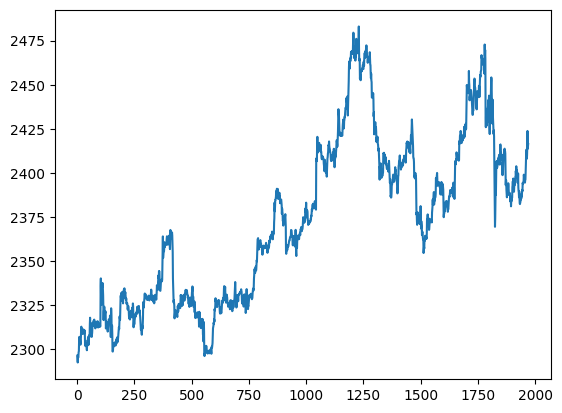

In [1926]:
plt.plot(gold['close'])

In [2055]:
# settings

TEST = 30
WINDOW = 6
SHAPE = 22 * WINDOW
TRAIN = 1900 - TEST

In [2056]:
drops = ['time', 'Open_time']

train = gold[:-1*TEST].drop(drops, axis=1)
test = gold[-1*TEST:].drop(drops, axis=1)

drops = ['time', 'label', 'Open_time']

In [2057]:
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

In [2058]:
train.head()

,open,high,low,close,volume,5SMA-Close,10m-WMA-Close,std_20,std_30,t-1_close,t-2_close,t-3_close,change,label,bull
0,2295.47,2297.19,2294.36,2296.48,4579,2293.860,2294.354182,2.187560,5.650887,2295.47,2291.17,2290.53,1.01,-1.0,0
1,2296.49,2297.50,2294.57,2294.92,5126,2293.714,2294.406545,2.132526,5.039080,2296.48,2295.47,2291.17,-1.57,-1.0,0
2,2294.92,2297.44,2292.44,2292.59,4758,2294.126,2294.064727,2.212399,4.264172,2294.92,2296.48,2295.47,-2.33,1.0,1
3,2292.59,2296.81,2291.79,2296.23,4571,2295.138,2294.433455,2.088054,3.714718,2292.59,2294.92,2296.48,3.64,-1.0,0
4,2296.26,2297.44,2294.64,2295.28,3696,2295.100,2294.606000,1.958731,3.251862,2296.23,2292.59,2294.92,-0.98,1.0,0


In [2059]:
X_train = []
y_train = []

for i in range(WINDOW, len(train)):
  X_train.append(train.drop('label',axis=1)[i-WINDOW:i].to_numpy())
  y_train.append(train['label'][i])

In [2060]:
test.reset_index(inplace=True)
test.drop(['index'], axis=1, inplace=True)
X_test = []
y_test = []

for i in range(WINDOW, len(test)):
  X_test.append(test.drop('label',axis=1)[i-WINDOW:i].to_numpy())
  y_test.append(test['label'][i])

In [2061]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [2062]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

lst = ['open', 'high', 'low', 'close', 'volume', '3SMA-Close',
       '5SMA-Close', '7SMA-Close', '03m-WMA-Close', '05m-WMA-Close',
       '07m-WMA-Close', '03m-RSI_Close', '05m-RSI_Close', '07m-RSI_Close',
       't-1_close', 't-2_close', 't-3_close', 't-3_high', 't-3_low',
       't-4_close', 't-5_close']

for column in range(len(X_train)):
    X_train[column] = scaler.fit_transform(X_train[column])
for column in range(len(X_test)):
    X_test[column] = scaler.fit_transform(X_test[column]) 

In [2063]:
X_train = X_train.reshape(X_train.shape[0], WINDOW*X_train.shape[2])
X_test = X_test.reshape(TEST-WINDOW, WINDOW*X_test.shape[2])

In [2064]:
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [4, 6, 10, 12],
#     'criterion': ['gini', 'entropy'],
#     'max_leaf_nodes': [2, 4, 6]
# }

# # Initialize the Random Forest model
# rf = RandomForestClassifier()

# # Initialize Grid Search with cross-validation
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# # Fit Grid Search on training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)

In [2065]:
model = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=12)
model3 = LogisticRegression()
model4 = KNeighborsClassifier()
model5 = MLPClassifier()

model.fit(X_train, y_train)
# model3.fit(X_train, y_train)
# model4.fit(X_train, y_train)
# model5.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=200, random_state=1)

In [2066]:
pred = model.predict(X_test)
# pred3 = model3.predict(X_test)
# pred4 = model4.predict(X_test)
# pred5 = model5.predict(X_test)

In [2067]:
y_test[-1] = 0

In [2071]:
print('RF', f1_score(y_test, pred, average='macro'))
print('RF accuracy of buys', f1_score(y_test, pred, average=None)[-1])
# print('LR', f1_score(pred3, y_test, average='weighted'))
# print('KNN', f1_score(pred4, y_test, average='weighted'))
# print('MLP', f1_score(pred5, y_test, average='weighted'))

RF 0.6079524340393906
RF accuracy of buys 0.6956521739130435


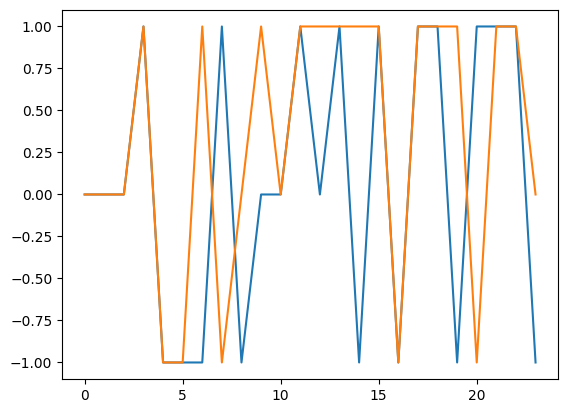

In [2069]:
df = pd.DataFrame({'x' : pred, 'y' : y_test})
plt.plot(df)

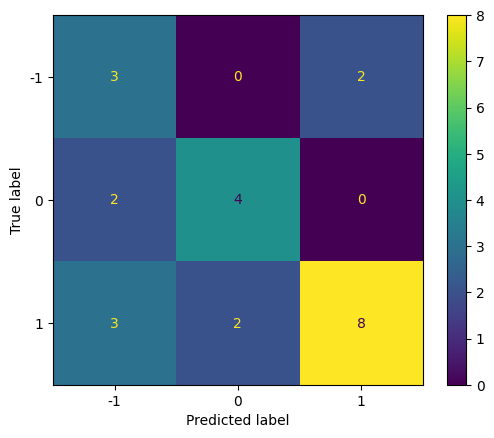

In [2070]:
cm = confusion_matrix(y_test, pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [-1, 0, 1])
cm_display.plot()

### an almost confident buy order can be placed